## Загрузка и обзор данных.

Импорт библиотек

In [1]:
import time
import math as mth
import numpy as np
import pandas as pd
import scipy.stats as st
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
plt.style.use('Solarize_Light2')

Функция для замены значений в столбце.

In [3]:
def rename (row):
    if 'contacts' in row:
        return 'contacts_show'
    elif 'search' in row:
        return 'search'
    else:
        return row

Функция для создания пользовательских профилей.

In [4]:
def get_profiles(sessions):

    # сортируем сессии по ID пользователя и дате посещения
    # группируем по ID и находим первые значения session_start и channel
    # столбец с временем первого посещения назовём first_ts
    # от англ. first timestamp — первая временная отметка
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby(['user_id','first_vizit'])
        .agg({'session_duration': 'sum', 'event_name': 'count',
              'user_sessions': 'nunique', 'source':'first'})
        .rename(columns={'event_name': 'events_number', 'user_sessions': 'sessions_number'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    # эти данные понадобятся для когортного анализа
    profiles['dt'] = profiles['first_vizit'].dt.date
    profiles['month'] = profiles['first_vizit'].astype('datetime64[M]')

    return profiles

Функция для расчета удержания

In [5]:
def get_retention(
    profiles, sessions, observation_date, horizon_days, dimensions=[], ignore_horizon=True
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'lifetime']], on='user_id', how='left'
    )
   
    # рассчитываем удержание
    result_grouped = (
        result_raw.pivot_table(
        index=dimensions, columns='lifetime', values='user_id', aggfunc='nunique'
    )
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes
    
    #result_grouped = result_grouped[['cohort_size',6,13]]

    # возвращаем таблицу удержания и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped

Функция для проверки статистической разницы между выборками.

`group_1`, `group_2` - количество уникальных клиентов в группе на этапе 

`total_number_1` , `total_number_2`-  общее число уникальных клиентов в группе

`alpha_current` - актуальное значение альфа

In [6]:
def verify_sample (group_1, group_2, total_number_1, total_number_2, alpha_current):
    alpha = alpha_current  # критический уровень статистической значимости / на число гипотез
    
    group_vizits = np.array([group_1, group_2])
    group_user = np.array([total_number_1 , total_number_2])
    
    p1 = group_vizits[0] / group_user[0]
    p2 = group_vizits[1] / group_user[1]
    
    p_combined = (group_vizits[0] + group_vizits[1]) / (group_user[1] + group_user[0])
    difference = p1 - p2
    
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/group_user[0] + 1/group_user[1]))
    distr = st.norm(0, 1)
    
    p_value = (1 - distr.cdf(abs(z_value))) * 2 
    
    print('p-значение: ', p_value)
    
    if p_value < alpha: 
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Сохраняем данные в переменных

In [7]:
user_source = pd.read_csv('mobile_soures.csv')
events = pd.read_csv('mobile_dataset.csv')

Ознакомимся с общими данными по таблицам: названием столбцов, количеством записей, типом данных

In [8]:
print('user_source')
user_source.info()
print('')
print('events')
events.info()

user_source
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB

events
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


Переименуем названия колонок для дальнейшего соединения таблиц.

In [9]:
user_source = user_source.rename(columns={'userId': 'user_id'})
events = events.rename(columns={'event.time': 'event_time', 'event.name': 'event_name', 'user.id':'user_id'})
print(user_source.columns)
print(events.columns)

Index(['user_id', 'source'], dtype='object')
Index(['event_time', 'event_name', 'user_id'], dtype='object')


Соединяем таблицы по колонке `user_id`.

In [10]:
app_users_activity = events.merge(user_source, on='user_id', how='left')
display(app_users_activity.sample(10))

,event_time,event_name,user_id,source
39249,2019-10-22 20:36:28.968699,tips_show,36d72f1d-b562-41b4-9888-49bce5c9e1cf,yandex
64397,2019-10-31 09:47:08.835276,tips_show,a899a360-2a35-4e49-b00c-0c1e4a231018,other
18845,2019-10-14 23:51:39.332391,favorites_add,f8576d27-c94e-4a2d-b293-074027bbe672,yandex
37689,2019-10-22 11:54:23.296102,search_5,9b795517-409a-4add-84a0-68ba7d4a5954,other
10802,2019-10-11 18:55:19.532471,tips_show,689677d5-7d3f-47af-9a27-56e88bbebce7,google
27692,2019-10-18 11:30:56.063146,advert_open,3521521c-99cb-4142-96cb-0b97cd5c60e6,yandex
5307,2019-10-09 09:35:47.128410,contacts_show,78e8c1af-ca3b-41e9-914c-66f74590b9b6,other
50231,2019-10-26 16:21:10.960617,tips_show,04d0b1b4-d31f-4c19-bc7e-14e5fcf6f791,yandex
8164,2019-10-10 14:57:55.101631,tips_show,017c6afc-965d-4c94-84ee-f0e326998e30,other
59530,2019-10-29 15:32:20.471928,tips_show,41f3d511-47cd-404e-9b28-3820a33f7090,other


Проверяем наличие пропусков.

In [11]:
app_users_activity.isnull().sum()

event_time    0
event_name    0
user_id       0
source        0
dtype: int64

Проверяем наличие дубликатов.

In [12]:
app_users_activity.duplicated().sum()

0

Объединим в столбце `event_name` значения `contacts_show` и `show_contacts`, `search_1` - `search_7`, для более наглядной воронки.

In [13]:
Counter(app_users_activity['event_name'])

Counter({'advert_open': 6164,
         'tips_show': 40055,
         'map': 3881,
         'contacts_show': 4450,
         'search_4': 701,
         'search_5': 1049,
         'tips_click': 814,
         'photos_show': 10012,
         'search_1': 3506,
         'search_2': 324,
         'search_3': 522,
         'favorites_add': 1417,
         'contacts_call': 541,
         'search_6': 460,
         'search_7': 222,
         'show_contacts': 79})

In [14]:
app_users_activity['event_name'] = app_users_activity['event_name'].apply(rename)
Counter(app_users_activity['event_name'])

Counter({'advert_open': 6164,
         'tips_show': 40055,
         'map': 3881,
         'contacts_show': 5070,
         'search': 6784,
         'tips_click': 814,
         'photos_show': 10012,
         'favorites_add': 1417})

Преобразуем дату и временя в нужный формат и округлим.

In [15]:
app_users_activity['event_time'] = pd.to_datetime(app_users_activity['event_time']).round('1s')
app_users_activity.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   source      74197 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.8+ MB


Выделим дату в отдельный столбец.

In [16]:
app_users_activity['date'] = app_users_activity['event_time'].dt.date
app_users_activity['date'] = pd.to_datetime(app_users_activity['date'])
app_users_activity.head()

,event_time,event_name,user_id,source,date
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07


In [17]:
app_users_activity['date'].max()

Timestamp('2019-11-03 00:00:00')

In [18]:
app_users_activity['date'].min()

Timestamp('2019-10-07 00:00:00')

Определяем самую ранюю дату открытия приложения для каждого клиента.

In [19]:
first_event = (
    app_users_activity.pivot_table(index='user_id', values='event_time', aggfunc='min')
    .reset_index()
    .rename(columns={'event_time': 'first_vizit'})
)       
first_event.head()

,user_id,first_vizit
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:46
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:34
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:06
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41


Соединяем основную таблицу и таблицу с первым посещением платформы.

In [20]:
app_users_activity = app_users_activity.merge(first_event, on='user_id', how='left')
app_users_activity.info()
app_users_activity.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   event_time   74197 non-null  datetime64[ns]
 1   event_name   74197 non-null  object        
 2   user_id      74197 non-null  object        
 3   source       74197 non-null  object        
 4   date         74197 non-null  datetime64[ns]
 5   first_vizit  74197 non-null  datetime64[ns]
dtypes: datetime64[ns](3), object(3)
memory usage: 4.0+ MB


,event_time,event_name,user_id,source,date,first_vizit
42797,2019-10-23 21:31:08,tips_show,4a692d22-992c-47d5-9676-9e6ffb11ca7d,yandex,2019-10-23,2019-10-23 21:14:33
72497,2019-11-03 15:37:07,tips_show,3ed35620-cf6c-47a9-aa80-dd54436a82ae,yandex,2019-11-03,2019-10-29 09:08:56
29370,2019-10-18 21:23:37,tips_show,a2311cac-437a-4e11-96d5-a492f5147771,other,2019-10-18,2019-10-18 20:55:58
6156,2019-10-09 15:18:42,tips_show,cb36854f-570a-41f4-baa8-36680b396370,yandex,2019-10-09,2019-10-07 11:39:43
41993,2019-10-23 17:38:16,tips_show,7af54793-05d6-4c51-ad67-de79e9f94c5d,yandex,2019-10-23,2019-10-23 17:21:10


Добавляем столбец с выделенным из даты днем недели.

In [21]:
app_users_activity['week_day'] = app_users_activity['event_time'].dt.day_name()
app_users_activity.sample(5)

,event_time,event_name,user_id,source,date,first_vizit,week_day
44217,2019-10-24 13:13:32,contacts_show,a3f24168-018f-49ee-8e1f-cc9c528d5aa4,google,2019-10-24,2019-10-24 12:36:48,Thursday
65695,2019-10-31 16:44:03,tips_show,abdcbe3c-221b-4f59-afd9-bf9ca78f7e4c,google,2019-10-31,2019-10-11 12:16:26,Thursday
60033,2019-10-29 18:06:35,tips_show,7cc49431-c898-412c-82c3-172fe0cd5f2d,yandex,2019-10-29,2019-10-21 17:58:39,Tuesday
40888,2019-10-23 13:52:36,tips_show,230b1f7a-17c1-4ee6-b8f3-a996f1a3b7e3,yandex,2019-10-23,2019-10-23 13:39:54,Wednesday
71188,2019-11-02 22:39:19,advert_open,8d9f19b7-1ec9-401e-82f4-2b2d026d89c6,yandex,2019-11-02,2019-11-01 18:37:59,Saturday


In [22]:
app_users_activity.duplicated().sum()

1194

Дубликаты появились из-за округления времени до секунд. 1,6% от всех записей, можно не удалять.

## Исследовательский анализ данных

Рассмотрим распределение данных. Данных для работы достаточно.

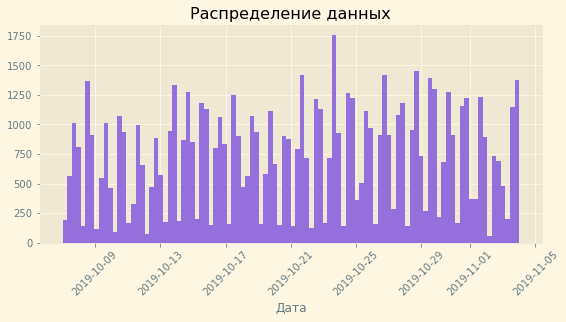

In [23]:
plt.figure(figsize=(9, 4))
app_users_activity['event_time'].hist(bins=100, color='mediumpurple')
plt.xticks(rotation=45)
plt.title('Распределение данных')
plt.xlabel('Дата')
plt.ylabel('')
plt.show()

Все пользователи пришли через один источник привлечения.

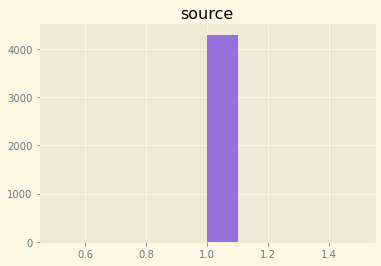

In [24]:
(
    app_users_activity.groupby('user_id')['source'].nunique()
    .reset_index()
    .hist(grid=True, color='mediumpurple')
);

Выделяем пользовательские сессии по 20 минут. Примерно такое количество времени пользователи без отрыва за один раз проводят в приложении.

In [25]:
g = app_users_activity[['user_id','event_time']].sort_values(by='event_time')
g = (g.groupby('user_id')['event_time'].diff() > pd.Timedelta('20Min')).cumsum()
app_users_activity['user_sessions'] = app_users_activity.groupby(['user_id', g], sort=False).ngroup() + 1
display(app_users_activity.head())


,event_time,event_name,user_id,source,date,first_vizit,week_day,user_sessions
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019-10-07 00:00:02,Monday,2
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019-10-07 00:00:02,Monday,2


Расчет время начала сессий. Группируем таблицу по номеру сессий и находим самое маленькое значение времени для каждой сессии.

In [26]:
temp = (
    app_users_activity.pivot_table(index=('user_sessions'), values='event_time', aggfunc='min')
    .reset_index()
    .rename(columns={'event_time': 'session_start'})   
)
temp.head()

,user_sessions,session_start
0,1,2019-10-07 00:00:00
1,2,2019-10-07 00:00:02
2,3,2019-10-07 00:02:07
3,4,2019-10-07 00:05:20
4,5,2019-10-07 00:09:34


Присоединяем таблицу с началом сессий к основной таблице. 

In [27]:
app_users_activity = app_users_activity.merge(temp, on='user_sessions', how='left')
app_users_activity.info()
app_users_activity.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   event_time     74197 non-null  datetime64[ns]
 1   event_name     74197 non-null  object        
 2   user_id        74197 non-null  object        
 3   source         74197 non-null  object        
 4   date           74197 non-null  datetime64[ns]
 5   first_vizit    74197 non-null  datetime64[ns]
 6   week_day       74197 non-null  object        
 7   user_sessions  74197 non-null  int64         
 8   session_start  74197 non-null  datetime64[ns]
dtypes: datetime64[ns](4), int64(1), object(4)
memory usage: 5.7+ MB


,event_time,event_name,user_id,source,date,first_vizit,week_day,user_sessions,session_start
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019-10-07 00:00:02,Monday,2,2019-10-07 00:00:02
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019-10-07 00:00:02,Monday,2,2019-10-07 00:00:02


Расчет времени окончания сессий. Группируем таблицу по номеру сессий и находим самое большое значение времени для каждой сессии.

In [28]:
temp = (
    app_users_activity.pivot_table(index=['user_sessions', 'session_start'], values='event_time', aggfunc='max')
    .reset_index()
    .rename(columns={'event_time': 'session_end'})   
)
temp.head()

,user_sessions,session_start,session_end
0,1,2019-10-07 00:00:00,2019-10-07 00:18:43
1,2,2019-10-07 00:00:02,2019-10-07 00:41:40
2,3,2019-10-07 00:02:07,2019-10-07 00:30:22
3,4,2019-10-07 00:05:20,2019-10-07 00:05:23
4,5,2019-10-07 00:09:34,2019-10-07 00:50:22


Присоединяем таблицу к основной таблице.

In [29]:
app_users_activity = app_users_activity.merge(temp, on=['user_sessions','session_start'], how='left')
app_users_activity.head(5)

,event_time,event_name,user_id,source,date,first_vizit,week_day,user_sessions,session_start,session_end
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00,2019-10-07 00:18:43
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00,2019-10-07 00:18:43
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019-10-07 00:00:02,Monday,2,2019-10-07 00:00:02,2019-10-07 00:41:40
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00,2019-10-07 00:18:43
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019-10-07 00:00:02,Monday,2,2019-10-07 00:00:02,2019-10-07 00:41:40


Вычисляем длительность сессий в секундах. Время окончания сессии - время начала сессии.

In [30]:
app_users_activity['session_duration'] = (
    pd.to_timedelta((app_users_activity['session_end'] - app_users_activity['session_start']))
    .dt.total_seconds()
    .astype('int') 
)
app_users_activity.info()
app_users_activity.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   event_time        74197 non-null  datetime64[ns]
 1   event_name        74197 non-null  object        
 2   user_id           74197 non-null  object        
 3   source            74197 non-null  object        
 4   date              74197 non-null  datetime64[ns]
 5   first_vizit       74197 non-null  datetime64[ns]
 6   week_day          74197 non-null  object        
 7   user_sessions     74197 non-null  int64         
 8   session_start     74197 non-null  datetime64[ns]
 9   session_end       74197 non-null  datetime64[ns]
 10  session_duration  74197 non-null  int64         
dtypes: datetime64[ns](5), int64(2), object(4)
memory usage: 6.8+ MB


,event_time,event_name,user_id,source,date,first_vizit,week_day,user_sessions,session_start,session_end,session_duration
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00,2019-10-07 00:18:43,1123
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00,2019-10-07 00:18:43,1123
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019-10-07 00:00:02,Monday,2,2019-10-07 00:00:02,2019-10-07 00:41:40,2498
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00,2019-10-07 00:18:43,1123
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019-10-07 00:00:02,Monday,2,2019-10-07 00:00:02,2019-10-07 00:41:40,2498


Вычисляем лайфтайм для каждой сессии в днях. Время начала сессии - дата и время первого появления в приложении пользователя.

In [31]:
app_users_activity['lifetime'] = (
    app_users_activity['session_start'] - app_users_activity['first_vizit']
).dt.days

app_users_activity.head(5)

,event_time,event_name,user_id,source,date,first_vizit,week_day,user_sessions,session_start,session_end,session_duration,lifetime
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00,2019-10-07 00:18:43,1123,0
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00,2019-10-07 00:18:43,1123,0
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019-10-07 00:00:02,Monday,2,2019-10-07 00:00:02,2019-10-07 00:41:40,2498,0
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00,2019-10-07 00:18:43,1123,0
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019-10-07 00:00:02,Monday,2,2019-10-07 00:00:02,2019-10-07 00:41:40,2498,0


Выведем график с количеством уникальных пользователей по дням. По нему можно сказать, что количество пользователей увеличивается.

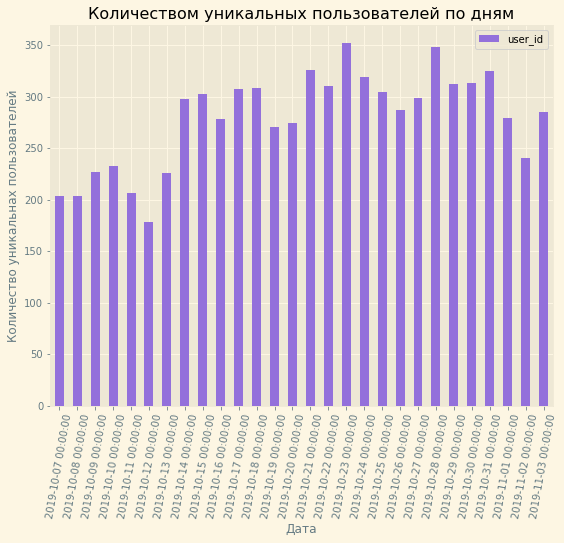

In [32]:
(
    app_users_activity.pivot_table(index=('date'), values='user_id', aggfunc='nunique')
    .reset_index()
    .plot(x='date', y='user_id', kind='bar',figsize=(9, 7), grid=True, color='mediumpurple')
)
plt.title('Количеством уникальных пользователей по дням')
plt.xlabel('Дата')
plt.ylabel('Количество уникальнах пользователей')
plt.xticks(rotation=80);

Графики рейтинга дней недели по количеству уникальных пользователей. По субботам количество клиентов на платформе сервиса самое низкое, возможно связано с наличием занятости личными делами. Самые высокие показатели по средам, понедельникам и четвергам, думаю, связано с тем, что люди используют сервис по дороге на работу и домой, а так же в офисе в перерывах между занятостью.

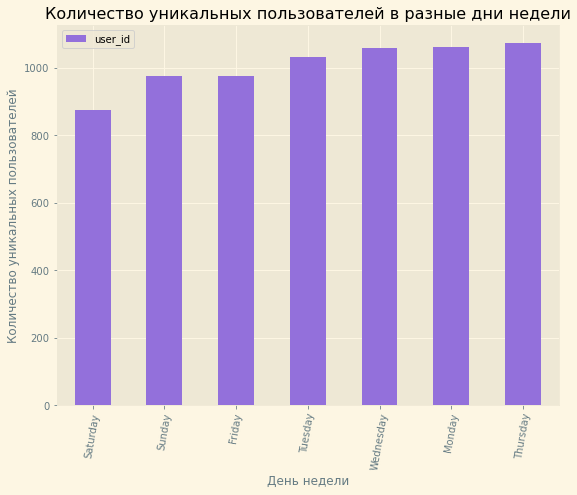

In [33]:
(
    app_users_activity.pivot_table(index=('week_day'), values='user_id', aggfunc='nunique')
    .reset_index()
    .sort_values(by='user_id')
    .plot(x='week_day', y='user_id', kind='bar',figsize=(9, 7), grid=True, color='mediumpurple')
)
plt.title('Количество уникальных пользователей в разные дни недели')
plt.xlabel('День недели')
plt.ylabel('Количество уникальных пользователей')
plt.xticks(rotation=80);

Графики рейтинга дней недели по количеству совершению целевого действия (просмотр контактов "contacts_show"). Наименьшее количество просмотров контактов происходит по субботам, самое большое количество по четвергам. На мой взгляд сязано с теми же процессами: наличием личных дел по выходным и свободным временем на работе и во время поездок в транспорте.

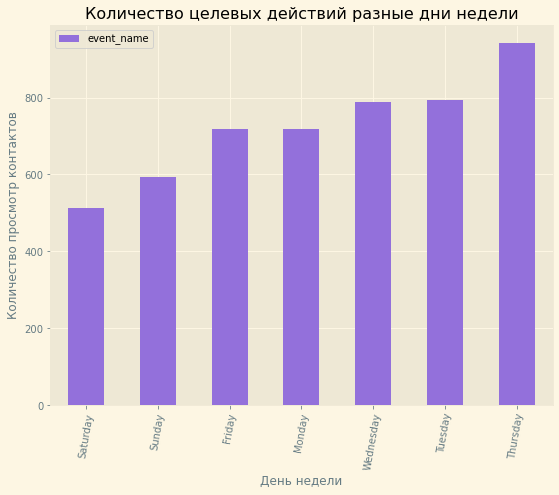

In [34]:
(
    app_users_activity.query('"contacts_show" in event_name')
    .pivot_table(index=('week_day'), values='event_name', aggfunc='count')
    .reset_index()
    .sort_values(by='event_name')
    .plot(x='week_day', y='event_name', kind='bar',figsize=(9, 7), grid=True, color='mediumpurple')
)
plt.title('Количество целевых действий разные дни недели')
plt.xlabel('День недели')
plt.ylabel('Количество просмотр контактов')
plt.xticks(rotation=80);

Отобразим рейтинг действий на платформе. Показ рекомендованных объявлений является самым популярным действием, целевое действие (просмотр контактов) находится в середине рейтинга, а переход в карточку рекомендованного объявления - наиболее редкое действие.  tips_show показывается всем пользователям автоматически и не зависит от действий.

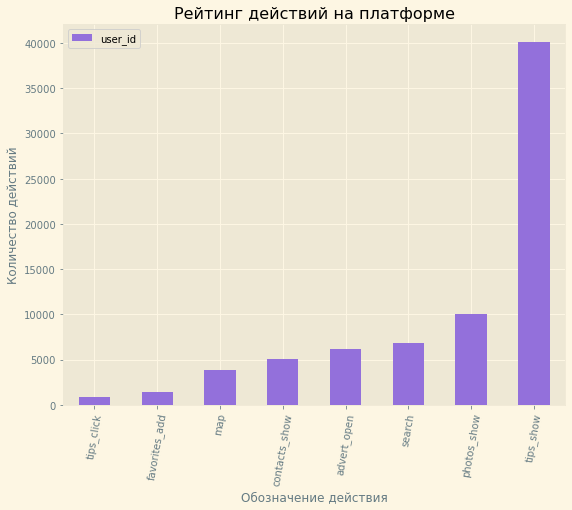

In [35]:
(   app_users_activity.pivot_table(index=('event_name'), values='user_id', aggfunc='count')
    .reset_index()
    .sort_values(by='user_id')
    .plot(x='event_name', y='user_id', kind='bar',figsize=(9, 7), grid=True, color='mediumpurple')
)
plt.title('Рейтинг действий на платформе')
plt.xlabel('Обозначение действия')
plt.ylabel('Количество действий')
plt.xticks(rotation=80);

График количества пользователей пришедших из разных источников. Через yandex пришло наибольшее количество пользователей,через google и другие примерно поровну. 

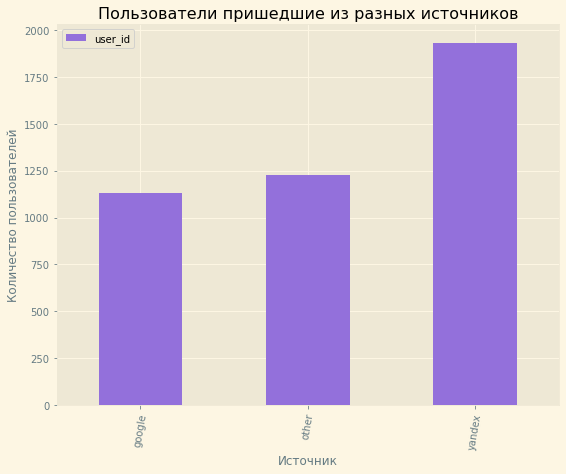

In [36]:
(   app_users_activity.pivot_table(index=('source'), values='user_id', aggfunc='nunique')
    .reset_index()
    .sort_values(by='user_id')
    .plot(x='source', y='user_id', kind='bar',figsize=(9, 7), grid=True, color='mediumpurple')
)
plt.title('Пользователи пришедшие из разных источников')
plt.xlabel('Источник')
plt.ylabel('Количество пользователей')
plt.xticks(rotation=80);

График конверсии относительно целевого действия (просмотр контактов "contacts_show"). Судя по графику не обязательно открывать карточку объявления. Прежде чем узнать контакты клиенты предпочитают посмотреть на фотографии и изучить карту.

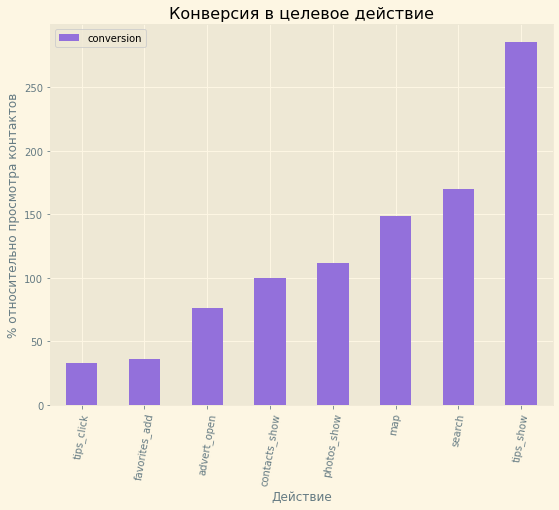

In [37]:
temp = (
    app_users_activity.groupby('event_name')['user_id'].nunique()  
    .reset_index()
)
temp['conversion'] = (
    round(temp['user_id'].div(app_users_activity
                              .query('"contacts_show" in event_name')['user_id']
                              .nunique(), axis=0) * 100, 1)
)
( temp.sort_values(by='conversion')
 .plot(x='event_name', y='conversion', kind='bar',figsize=(9, 7), grid=True, color='mediumpurple')
)
plt.title('Конверсия в целевое действие')
plt.xlabel('Действие')
plt.ylabel('% относительно просмотра контактов')
plt.xticks(rotation=80);

## Сегментация пользователей

Создаем профили пользователей. 

In [38]:
profiles = get_profiles(app_users_activity)
profiles.head()

,user_id,first_vizit,session_duration,events_number,sessions_number,source,dt,month
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:46,13544,35,8,other,2019-10-07,2019-10-01
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:34,13706,71,31,yandex,2019-10-19,2019-10-01
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35,3598,10,4,yandex,2019-11-01,2019-11-01
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:06,3155,32,17,google,2019-10-18,2019-10-01
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41,56,8,5,yandex,2019-10-25,2019-10-01


Добавим в таблицу значения среднего количества действий в лайфтайм и средней продолжительности сессии для каждого пользователя в секундах.

In [39]:
profiles['avg_events_per_session'] = (profiles['events_number'] / profiles['sessions_number']).astype('int')
profiles['avg_session_duration'] = (profiles['session_duration'] / profiles['sessions_number']).round().astype('int')

profiles.head()

,user_id,first_vizit,session_duration,events_number,sessions_number,source,dt,month,avg_events_per_session,avg_session_duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:46,13544,35,8,other,2019-10-07,2019-10-01,4,1693
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:34,13706,71,31,yandex,2019-10-19,2019-10-01,2,442
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35,3598,10,4,yandex,2019-11-01,2019-11-01,2,900
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:06,3155,32,17,google,2019-10-18,2019-10-01,1,186
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41,56,8,5,yandex,2019-10-25,2019-10-01,1,11


Записываем признаки в отдельную переменную и стандартизируем их. Для выделения кластеров я выбрала среднюю продолжительность сессий и среднее количество действий в сессию. Т.к. для нас важно изучить поведение пользователей, то, на мой взгляд, важно узнать чем отличаются пользователи проводящие много времени в приложении от тех, кто открывает приложение на непродолжительный срок.

In [40]:
X = profiles[['avg_events_per_session','avg_session_duration']]
sc = StandardScaler()
X_sc = sc.fit_transform(X)

Строим матрицу расстояний на стандартизированных данных и рисуем дендрограмму.

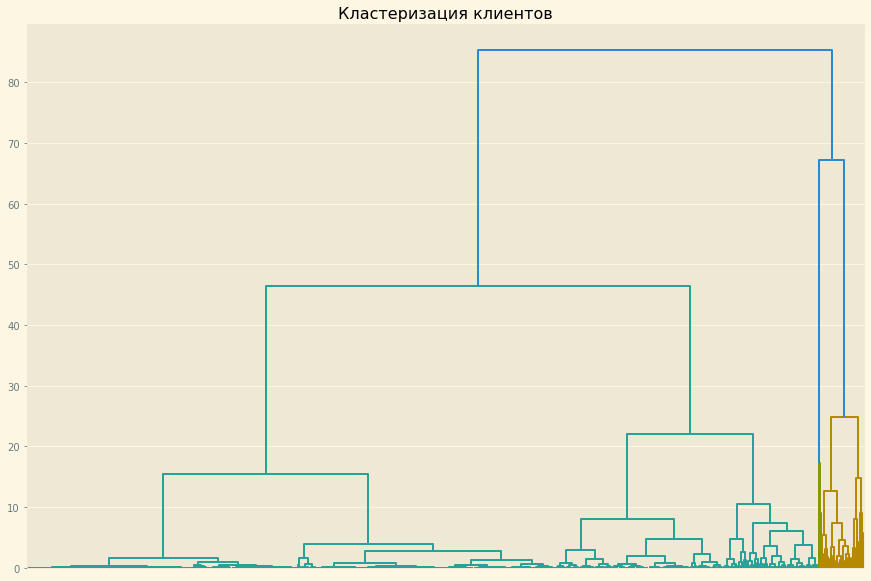

In [41]:
linked = linkage(X_sc, method = 'ward')
plt.figure(figsize=(15, 10))
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Кластеризация клиентов')
plt.show()

Разделим клиентов на 2 кластера. Самый объемный №1 объединил 4086 человек, №0 - 207. Кластер содержащий самое большое количество человек можно считать основным, второй по численности дополнительным.

In [42]:
km = KMeans(n_clusters=2, random_state=0) 
labels = km.fit_predict(X_sc)
profiles['cluster'] = labels
profiles.groupby('cluster')['user_id'].count().reset_index()

,cluster,user_id
0,0,207
1,1,4086


## Изучение групп пользователей

Рассмотрим *показатель удержания* двух кластеров. Удержание построено без учета горизонта анализа. В расчет вошли все пользователи, использовавшие приложение 7 октября 2019 года 14 дней. Основной кластер №1, самый многочисленный, показывает  удержание хуже,чем кластер №0. На 9 день использования приложения клиенты перестают заходить в него и лишь через несколько дней о нем вспоминают. 

In [43]:
print('Максимальный лайфтайм:',app_users_activity['lifetime'].max(), 
      'Максимальная дата:', app_users_activity['event_time'].max())

Максимальный лайфтайм: 26 Максимальная дата: 2019-11-03 23:58:13


In [44]:
retention_raw, retention = get_retention(
    profiles, app_users_activity, datetime(2019, 11, 3).date(),15, dimensions=['cluster'])

retention

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
cluster,,,,,,,,,,,,,,,,
0,207,1.0,0.033816,0.024155,0.033816,0.009662,0.014493,0.014493,0.004831,0.004831,0.000000,0.000000,0.000000,0.000000,0.004831,0.000000
1,4086,1.0,0.111845,0.088350,0.068037,0.057758,0.053108,0.051640,0.050416,0.041850,0.028879,0.026187,0.024963,0.023005,0.023495,0.020803


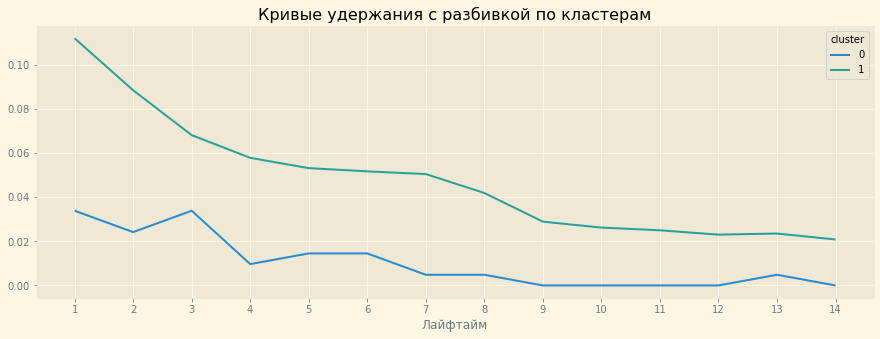

In [45]:
report = retention.drop(columns=['cohort_size', 0])
report.T.plot(grid=True, xticks=list(report.columns.values), figsize=(15, 5))
plt.xlabel('Лайфтайм')
plt.title('Кривые удержания с разбивкой по кластерам')
plt.show()

*Время проведенное в приложении*.

По медиане средней продолжительности сессии лидирует кластер №0 - 6000 секунд, в минутах 100.Второе место у кластера №2 280 секунд - 4,67 минут.

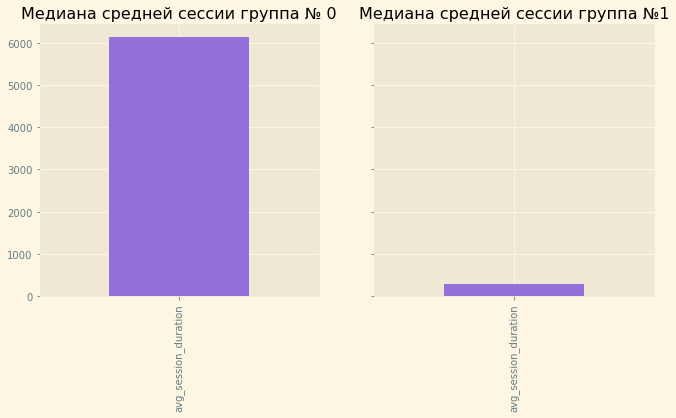

In [46]:
plt.figure(figsize=(11, 5))
ax1 = plt.subplot(1, 2, 1)
( 
    profiles.query('cluster == 0')
    .agg({'avg_session_duration': 'median'})
    .plot(kind='bar',grid=True, color='mediumpurple', ax=ax1)
)
plt.title('Медиана средней сессии группа № 0')

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
( 
    profiles.query('cluster == 1')
    .agg({'avg_session_duration': 'median'})
    .plot(kind='bar',grid=True, color='mediumpurple', ax=ax2)
)
plt.title('Медиана средней сессии группа №1')
    
     
plt.show()

*Количество действий за сессию*

Пользователи из группы №0 за одну сессию совершают примерно 8,5 действий, в группе №1 совершают 2 действия.

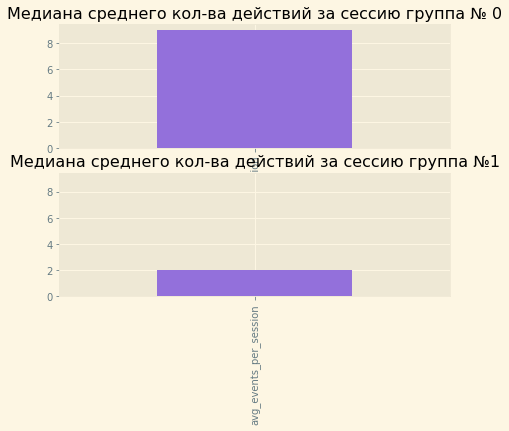

In [47]:
plt.figure(figsize=(7, 5))
ax1 = plt.subplot(2, 1, 1)
( 
    profiles.query('cluster == 0')
    .agg({'avg_events_per_session': 'median'})
    .plot(kind='bar',grid=True, color='mediumpurple', ax=ax1)
)
plt.title('Медиана среднего кол-ва действий за сессию группа № 0')

ax2 = plt.subplot(2, 1, 2, sharey=ax1)
( 
    profiles.query('cluster == 1')
    .agg({'avg_events_per_session': 'median'})
    .plot(kind='bar',grid=True, color='mediumpurple', ax=ax2)
)
plt.title('Медиана среднего кол-ва действий за сессию группа №1');

Посмотрим какие действия совершают пользователи двух этих групп. Присоединяем к основной таблице информацию о номере кластера.

In [48]:
app_users_activity = (
    app_users_activity.merge(profiles, on=['user_id'], how='left')
    
)
app_users_activity.head()

,event_time,event_name,user_id,source_x,date,first_vizit_x,week_day,user_sessions,session_start,session_end,...,first_vizit_y,session_duration_y,events_number,sessions_number,source_y,dt,month,avg_events_per_session,avg_session_duration,cluster
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00,2019-10-07 00:18:43,...,2019-10-07 00:00:00,31444,28,1,other,2019-10-07,2019-10-01,28,31444,0
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00,2019-10-07 00:18:43,...,2019-10-07 00:00:00,31444,28,1,other,2019-10-07,2019-10-01,28,31444,0
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019-10-07 00:00:02,Monday,2,2019-10-07 00:00:02,2019-10-07 00:41:40,...,2019-10-07 00:00:02,89425,93,22,yandex,2019-10-07,2019-10-01,4,4065,1
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00,2019-10-07 00:18:43,...,2019-10-07 00:00:00,31444,28,1,other,2019-10-07,2019-10-01,28,31444,0
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019-10-07 00:00:02,Monday,2,2019-10-07 00:00:02,2019-10-07 00:41:40,...,2019-10-07 00:00:02,89425,93,22,yandex,2019-10-07,2019-10-01,4,4065,1


In [49]:
app_users_activity = ( 
    app_users_activity.drop(['first_vizit_y','events_number','sessions_number',
                             'source_y','dt','month', 'avg_events_per_session',
                             'avg_session_duration', 'session_duration_y'], axis=1)
    .rename(columns={'source_x': 'source', 'first_vizit_x':'first_vizit',
                     'session_duration_x':'session_duration'})
    
)
app_users_activity.head()

,event_time,event_name,user_id,source,date,first_vizit,week_day,user_sessions,session_start,session_end,session_duration,lifetime,cluster
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00,2019-10-07 00:18:43,1123,0,0
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00,2019-10-07 00:18:43,1123,0,0
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019-10-07 00:00:02,Monday,2,2019-10-07 00:00:02,2019-10-07 00:41:40,2498,0,1
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07,2019-10-07 00:00:00,Monday,1,2019-10-07 00:00:00,2019-10-07 00:18:43,1123,0,0
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07,2019-10-07 00:00:02,Monday,2,2019-10-07 00:00:02,2019-10-07 00:41:40,2498,0,1


Группа №0 открывает много карточек объявлений, фотографий, пользуются поиском и картой. Группа №1 предпочитает просматривать фотографии, использовать поиск, а затем открывать карточку объявления для просмотра контактов.

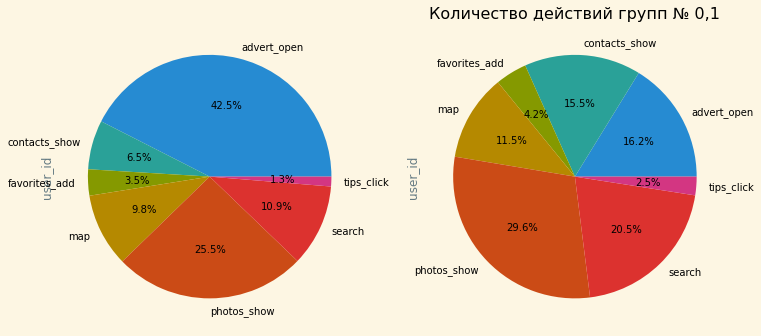

In [50]:
number = [0,1]
a=0
fig, axs = plt.subplots(1, len(number),figsize=(12,10))

for i in number:
    (app_users_activity.query('cluster == @i & "tips_show" not in event_name')
     .groupby('event_name')['user_id'].count()
     .plot(ax=axs[a],kind='pie', autopct='%1.1f%%')
    )
    plt.title('Количество действий групп № 0,1')
    a += 1


plt.show()

Наименее популярные действия: переход на страницу рекламного объявления и добавление товара в избранное.

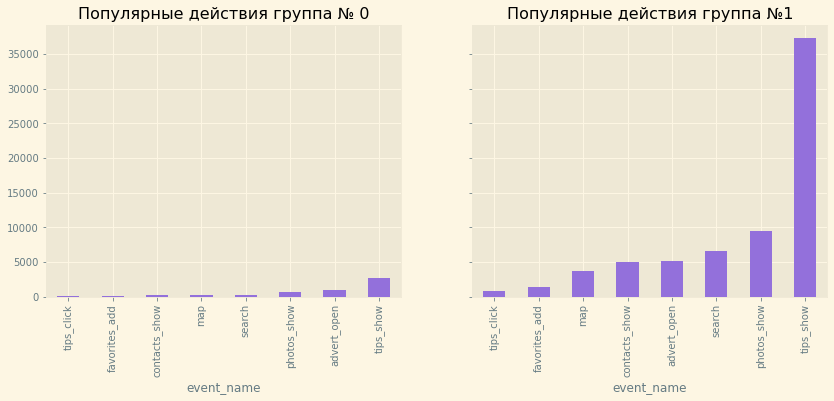

In [51]:
plt.figure(figsize=(14, 5))
ax1 = plt.subplot(1, 2, 1)
( 
    app_users_activity.query('cluster == 0')
    .groupby('event_name')['user_id'].count()
    .sort_values()
    .plot(kind='bar',grid=True, color='mediumpurple', ax=ax1)
)
plt.title('Популярные действия группа № 0')

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
( 
    app_users_activity.query('cluster == 1')
    .groupby('event_name')['user_id'].count()
    .sort_values()
    .plot(kind='bar',grid=True, color='mediumpurple', ax=ax2)
)
plt.title('Популярные действия группа №1') ;

Посмотрим на конверсию в целевое действие - просмотр контактов. Группа №0 демонстрирует лучшую конверсию, чем группа №1.

In [52]:
temp_table_event = (
    app_users_activity.query('"contacts_show" in event_name')
    .pivot_table(index='cluster', values='user_id', aggfunc='nunique')  
    .reset_index()
    .rename(columns={'user_id': 'contacts_show'})
)
temp_table_event

,cluster,contacts_show
0,0,33
1,1,948


In [53]:
temp = (
    app_users_activity.pivot_table(index='cluster', values='user_id', aggfunc='nunique')
    .rename(columns={'user_id': 'user_count'})
    .reset_index()
)
temp

,cluster,user_count
0,0,207
1,1,4086


,cluster,contacts_show,user_count,conresion
0,0,33,207,15.942029
1,1,948,4086,23.201175


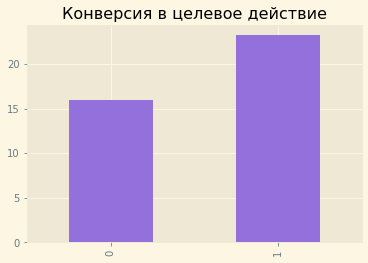

In [54]:
temp_table_event = temp_table_event.merge(temp, on='cluster')
temp_table_event['conresion'] = (temp_table_event['contacts_show'].div(temp_table_event['user_count'], axis=0))*100
display(temp_table_event)
temp_table_event['conresion'].plot(kind='bar',grid=True, color='mediumpurple')
plt.title('Конверсия в целевое действие') ;

Изучим сколько времени проходит с момента первого входа в приложение до использования функции поиска.

In [55]:
temp = (
    app_users_activity.query('"search" in event_name')
    .pivot_table(index=['user_id','cluster','first_vizit'], values='event_time', aggfunc='min')
    .reset_index()
)
print(Counter(temp['cluster']))
temp.head()

Counter({1: 1586, 0: 80})


,user_id,cluster,first_vizit,event_time
0,00157779-810c-4498-9e05-a1e9e3cedf93,1,2019-10-19 21:34:34,2019-10-19 21:34:34
1,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,1,2019-10-18 22:14:06,2019-10-18 22:14:06
2,00551e79-152e-4441-9cf7-565d7eb04090,1,2019-10-25 16:44:41,2019-10-28 13:08:16
3,00554293-7e00-4122-b898-4e892c4a7c53,1,2019-10-27 12:32:28,2019-10-27 12:32:28
4,00753c79-ea81-4456-acd0-a47a23ca2fb9,1,2019-10-20 14:57:06,2019-10-23 08:53:33


Вычисляем продолжительность этого периода

In [56]:
temp['duratin'] = (temp['event_time'] - temp['first_vizit']).dt.total_seconds() / 60
temp.head()

,user_id,cluster,first_vizit,event_time,duratin
0,00157779-810c-4498-9e05-a1e9e3cedf93,1,2019-10-19 21:34:34,2019-10-19 21:34:34,0.000000
1,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,1,2019-10-18 22:14:06,2019-10-18 22:14:06,0.000000
2,00551e79-152e-4441-9cf7-565d7eb04090,1,2019-10-25 16:44:41,2019-10-28 13:08:16,4103.583333
3,00554293-7e00-4122-b898-4e892c4a7c53,1,2019-10-27 12:32:28,2019-10-27 12:32:28,0.000000
4,00753c79-ea81-4456-acd0-a47a23ca2fb9,1,2019-10-20 14:57:06,2019-10-23 08:53:33,3956.450000


Считаем среднее по кластерам в минутах. Группа пользователей №1 на много позже начинает использовать функцию поиска.

cluster
0    110.625625
1    972.764975
Name: duratin, dtype: float64


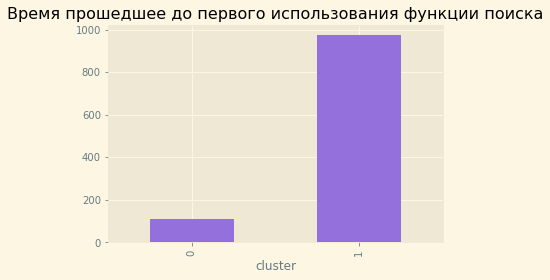

In [57]:
print(temp.groupby('cluster')['duratin'].mean())
temp.groupby('cluster')['duratin'].mean().plot(kind='bar', grid=True, color='mediumpurple')
plt.show
plt.title('Время прошедшее до первого использования функции поиска') ;

## Проверка гипотез

Гипотеза H0: пользователи пришедшие через yandex и пользователи установившие приложение через google демонстрируют схожую конверсию в просмотры контактов.

Гипотеза H1: пользователи пришедшие через yandex и пользователи установившие приложение через google демонстрируют разную конверсию в просмотры контактов.

Количество уникальных пользователей в тестируемых группах.

In [58]:
unique_user = (
    app_users_activity.pivot_table(index='source', values='user_id', aggfunc='nunique')
    .reset_index()
)
unique_user

,source,user_id
0,google,1129
1,other,1230
2,yandex,1934


Количество уникальных пользователей пришедших из разных источников совершивших целевое действие "просмотр контактов".

In [59]:
test_user = (
        app_users_activity.query('"contacts_show" in event_name')
        .pivot_table(index=['source'],  values='user_id', aggfunc='nunique')
        .reset_index()
    )
test_user

,source,user_id
0,google,275
1,other,228
2,yandex,478


In [60]:
group_1 = test_user.loc[0,'user_id']
group_2 = test_user.loc[2,'user_id']
total_number_1 = unique_user.loc[0,'user_id']
total_number_2 = unique_user.loc[2,'user_id']

alpha_current = 0.05 / 5

verify_sample(group_1, group_2, total_number_1, total_number_2, alpha_current)

p-значение:  0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Гипотеза H0: есть статистическая разница между конверсией в целевое действие "просмотр контактов" по пятницам и по субботам.

Гипотеза H1: есть статистическая разница между конверсией в целевое действие "просмотр контактов" по пятницам и по субботам.

Количество пользователей в разные дни недели.

In [61]:
unique_user = (app_users_activity
               .pivot_table(index=('week_day'), values='user_id', aggfunc='nunique')
               .reset_index()
)
unique_user

,week_day,user_id
0,Friday,976
1,Monday,1060
2,Saturday,873
3,Sunday,975
4,Thursday,1074
5,Tuesday,1032
6,Wednesday,1058


Количество пользователей открывших контакты продавца в разные дни недели.

In [62]:
test_user = (app_users_activity.query('"contacts_show" in event_name')
             .pivot_table(index=('week_day'), values='user_id', aggfunc='nunique')
    .reset_index()
)
test_user

,week_day,user_id
0,Friday,209
1,Monday,186
2,Saturday,163
3,Sunday,187
4,Thursday,213
5,Tuesday,206
6,Wednesday,191


In [63]:
group_1 = test_user.loc[0,'user_id']
group_2 = test_user.loc[2,'user_id']
total_number_1 = unique_user.loc[0,'user_id']
total_number_2 = unique_user.loc[2,'user_id']

alpha_current = 0.05 / 5

verify_sample(group_1, group_2, total_number_1, total_number_2, alpha_current)

p-значение:  0.14193093355856856
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Гипотеза H0: нет статистической разницы между конверсией в целевое действие "просмотр контактов" по субботам и по средам.

Гипотеза H1: есть статистическая разница между конверсией в целевое действие "просмотр контактов" по субботам и по средам.

In [64]:
group_1 = test_user.loc[2,'user_id']
group_2 = test_user.loc[6,'user_id']
total_number_1 = unique_user.loc[2,'user_id']
total_number_2 = unique_user.loc[6,'user_id']

alpha_current = 0.05 / 5

verify_sample(group_1, group_2, total_number_1, total_number_2, alpha_current)

p-значение:  0.7267208064987329
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Гипотеза H0: нет статистической разницы между количеством посетителей приложения по пятницам и по субботам.

Гипотеза H1: есть статистическая разница между количеством посетителей приложения по пятницам и по субботам.

Общее количество уникальных пользователей.

In [65]:
unique_user = app_users_activity['user_id'].nunique()

unique_user

4293

Количество уникальных пользователей в разные дни недели.

In [66]:
test_user = (app_users_activity
             .pivot_table(index=('week_day'), values='user_id', aggfunc='nunique')
             .reset_index()
)
test_user

,week_day,user_id
0,Friday,976
1,Monday,1060
2,Saturday,873
3,Sunday,975
4,Thursday,1074
5,Tuesday,1032
6,Wednesday,1058


In [67]:
group_1 = test_user.loc[0,'user_id']
group_2 = test_user.loc[2,'user_id']
total_number_1 = unique_user
total_number_2 = unique_user

alpha_current = 0.05 / 5

verify_sample(group_1, group_2, total_number_1, total_number_2, alpha_current)

p-значение:  0.006847916448061708
Отвергаем нулевую гипотезу: между долями есть значимая разница


Гипотеза H0: нет статистической разницы между количеством посетителей приложения по субботам и по средам.

Гипотеза H1: есть статистическая разница между количеством посетителей приложения по субботам и по средам.

In [68]:
group_1 = test_user.loc[2,'user_id']
group_2 = test_user.loc[6,'user_id']
total_number_1 = unique_user
total_number_2 = unique_user

alpha_current = 0.05 / 5

verify_sample(group_1, group_2, total_number_1, total_number_2, alpha_current)

p-значение:  1.7363165973893757e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница


## Выводы и рекомендации

*Общие выводы.* Количество пользователей приложения растет. По субботам количество клиентов на платформе сервиса самое низкое, возможно связано с тем, что в выходные много личных дел. Самые высокие показатели по средам, понедельникам и четвергам, думаю, что люди используют сервис по дороге на работу и домой, а так же в офисе в перерывах между занятостью. Наименьшее количество просмотров контактов происходит по субботам, самое большое количество по четвергам. На мой взгляд связано с теми же процессами: наличием личных дел по выходным и свободным временем на работе и во время поездок в транспорте в будние дни. Показ рекомендованных объявлений является самым популярным действием, целевое действие (просмотр контактов) находится в середине рейтинга, а переход в карточку рекомендованного объявления - наиболее редкое действие. Через yandex пришло наибольшее количество пользователей,через google и другие примерно поровну. Советую обратить внимание на низкое количество переходов по рекламным объявлениям и изучить данный вопрос. Возможно имеет смысл оптимизаровать паказ объявлений в зависимости от запросов в поисковой строке, времени суток, дня недели, приближающихся праздников или ещё каких-либо факторов. 

На основании исследования двух групп пользователей поведение можно охарактеризовать следующим образом: клиенты в *кластере №0* подходят к поиску последовательно и основательно. В начале предпочитают открыть объявление о продаже и изучить основную информацию. Далее рассматривают фотографии. Обращаются к карте с местом продажи, при условии, что описание и внешний вид товара их удовлетворил. И уже затем открывают контакты продавца. За одну сессию пользователи проводят, примерно, в 4 раза больше манипуляций с платформой и много времени проводят в приложении. Конверсия в целевое действие почти 16%. Удержание у данного кластера на много хуже. Между первым входом в приложение и использованием поиска проходит в среднем 110 минут. Для взаимодействия с такими пользователи можно посоветовать добавить возможность просмотра описания товара (или некоторой части описания) без открытия карточки объявления. Возможно это удовлетворит пользователей данного кластера в потребности изучения данных товара и поможет им сэкономить время на открытиии и загрузке карточки объявления. Добавить возможность использования фильтров.

Про клиентов из *кластера №1* можем сказать следующее: они предпочитают часто вводить свои запросы в поиск, рассматривать фотографии. Открывают карточку товара только в том случае, если им нужны контакты продавца. Скорее всего задают уточняющую информацию продавцу и уже после этого изучают карту с местом продажи. За одну сессию совершают в среднем не очень много действий (2) и проводят примерно 4,6 минут в приложении. Конверсия в целевое действие 23%. После первого открытия приложения в среднем проходит 972 минуты до использования функции поиска. В качестве рекомендаций предлагаю усовершенствовать строчку поиска. Добавить в функционал подсказки по набору названий, запросов, уточнения категорий товаров сохранение истории поиска.

Во время исследования было выдвинуто и проверено 5 гипотез:
1. Пользователи пришедшие через yandex и пользователи установившие приложение через google демонстрируют одинаковую конверсию в просмотры контактов.
2. Нет статистической разницы между конверсией в целевое действие "просмотр контактов" по пятницам и по субботам.
3. Нет статистической разницы между конверсией в целевое действие "просмотр контактов" по субботам и по средам.
4. Нет статистической разницы между количеством посетителей приложения по пятницам и по средам.
5. Нет статистической разницы между количеством посетителей приложения по пятницам и по средам.

Я хотела проверить проявляют, ли пользователи одинаковую активность в выходной день (суббота) и в будний день (в середине недели), и в предвыходной день (пятница). По результатам теста - 3 гипотезы не получилось отвергнуть и 2 не получили подтверждение. Результаты следующие: есть разница между количеством посетителей в субботу и в пятницу, а также в субботу и среду. Нет статистической разницы между конверсией пользователей пришедших в приложение через yandex и через google. А так же не получилось опровергнуть гипотезу об отсутствии статистической разницы в конверсии в целевое действие между пятницей и субботой и между субботой и средой. Эти результаты можно использовать для оптимизации показа рекламных объявлений.

Ссылка на дашборд: <https://public.tableau.com/views/app_event/Dashboard1?:language=en-US&:display_count=n&:origin=viz_share_link>

Ссылка на презентацию: https://docs.google.com/presentation/d/1FafuxV8Ma-SNxv3muEn8oB61A8E4VDR-jFh_3GEyG0E/edit?usp=sharing